In [6]:
import os
import zipfile
from tensorflow import keras as tfk
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


# print python version
#print("Python VERSION:", sys.version)


"""
        Description:
        ------------
            CNN application to the emotions dataset, remeber to change the path 
            to the dataset in the beginning of the code.

        Parameters to tune:
        ------------
            I  Architecture of the CNN( Number and types of layers)
            II  Dimensions and number of the kernels (height and width) used for convolution and pooling
            III stride in the convolutional layers and pooling layers, padding or no padding
            IV  Numbers of epochs and batches ( 2 types of batches are used, one for the GD(in the fit function) and one for data preprocessing)
            V   Learning rate and regularization parameter ( lambda)
            VI  Activation functions ( sigmoid, tanh, relu, leaky relu, softmax)
            VII  Number of neurons in the fully connected layers
        """

# Path to the zip file and extraction directory
zip_path = r"/Users/carmen/archive.zip"
extraction_path = r"/Users/carmen/dataset"

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Set up directories
train_dir = os.path.join(extraction_path, 'train')
test_dir = os.path.join(extraction_path, 'test')

# Define image dimensions
img_width, img_height = 48, 48  # You can adjust this based on your specific dataset
#batch_size = 26 # You can adjust this based on your specific needs


# Load images using image_dataset_from_directory
train_dataset = tfk.utils.image_dataset_from_directory(
    train_dir,
    color_mode='grayscale', # or 'rgb' for colored images
    label_mode='categorical',  # or 'binary' if you have two classes
    #batch_size=batch_size,
    image_size=(img_width, img_height))


test_dataset = tfk.utils.image_dataset_from_directory(
    test_dir,
    color_mode='grayscale', # or 'rgb' for colored images
    label_mode='categorical',  # or 'binary' if you have two classes
    #batch_size=batch_size,
    image_size=(img_width, img_height))


# Data preprocessing and augmentation
# You can add your preprocessing layers here
preprocessing_model = tfk.Sequential([
    tfk.layers.Rescaling(1./255),  # Rescale pixel values
    # Add any additional preprocessing layers here
])


# Apply the preprocessing to the dataset
train_dataset = train_dataset.map(lambda x, y: (preprocessing_model(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocessing_model(x), y))
#train_dataset = train_dataset.take(200)
#test_dataset = test_dataset.take(40)


# To get the labels from the train dataset
train_labels = []
for _, labels in train_dataset:
    train_labels.extend(labels.numpy())

# Do the same for the test dataset
test_labels = []
for _, labels in test_dataset:
    test_labels.extend(labels.numpy())

# Now train_labels and test_labels contain the labels for their respective datasets

#Split the images from their target

x_train_list = []
t_train_list = []


# Iterate through the training dataset
for images, labels in train_dataset:
    # Append images and labels to the respective lists
    x_train_list.append(images.numpy())
    t_train_list.append(labels.numpy())


# Convert lists to numpy arrays
x_train = np.concatenate(x_train_list, axis=0)
t_train = np.concatenate(t_train_list, axis=0)

# Do the same for the test dataset
x_test_list = []
t_test_list = []

for images, labels in test_dataset:
    x_test_list.append(images.numpy())
    t_test_list.append(labels.numpy())

x_test = np.concatenate(x_test_list, axis=0)
t_test = np.concatenate(t_test_list, axis=0)


# Now you can use x_train, t_train, x_test, and t_test with your custom CNN

print("x train shape:", x_train.shape)
print("t train shape:", t_train.shape)
print("x test shape:", x_test.shape)
print("t test shape:", t_test.shape)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
x train shape: (28709, 48, 48, 1)
t train shape: (28709, 7)
x test shape: (7178, 48, 48, 1)
t test shape: (7178, 7)


{'Angry': 3995, 'Disgusted': 436, 'Fearful': 4097, 'Happy': 7215, 'Neutral': 4965, 'Sad': 4830, 'Surprised': 3171}
28709


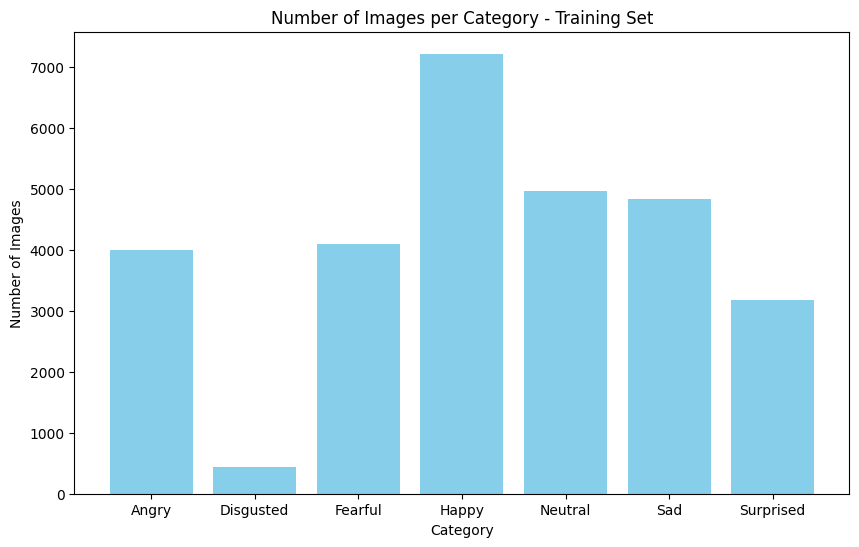

In [7]:
class_indices = np.argmax(t_train, axis=1)
classes = ["Angry", "Disgusted", "Fearful", "Happy", "Neutral", "Sad", "Surprised"]

# Count the occurrences of each class index
class_counts = np.bincount(class_indices)
categories = np.arange(len(class_counts))  # This will be your x-axis (the number of the category)
freq_classes = dict()
for i in categories:
    freq_classes[str(classes[i])] = class_counts[i]
print(freq_classes)
print(sum(freq_classes.values()))

# Plot the number of images per category
plt.figure(figsize=(10, 6))
plt.bar(freq_classes.keys(), freq_classes.values(), color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category - Training Set')
#plt.xticks()
plt.show()

In [8]:
num_classes = 7
batch_size_gd = 50
l2_lambda = 0.0001

model = models.Sequential()

# Convolutional Layer 1
model.add(layers.Conv2D(32, (3, 3),
                         activation='relu',
                           input_shape=(img_width, img_width, 1)))
# Max Pooling Layer 1
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(layers.Conv2D(64, (3, 3)
                        , activation='relu'))

# Max Pooling Layer 2
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(layers.Conv2D(64, (3, 3)
                        , activation='relu'))

# Max Pooling Layer 3
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))


# Flattening Layer
model.add(layers.Flatten())

# Fully Connected Layer 1 with L2 Regularization
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))

# Fully Connected Layer 2 with L2 Regularization
model.add(layers.Dense(7, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))

# Output Layer
model.add(layers.Dense(num_classes, activation='softmax'))

#display model architecture
model.summary()

learning_rate = 0.0001

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=r"best_model.pth",  # Corrected path
    monitor = "val_loss",
    verbose = 0,
    save_best_only = False,
    save_weights_only = False,
    mode = "auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None
)

# Train the model with L2 regularization
history = model.fit(
    x_train, t_train,
    batch_size=batch_size_gd,
    epochs=20,
    validation_data=(x_test, t_test),
    callbacks=[checkpoint_callback]  # Put the callback inside a list
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)         

INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 47s 78ms/step - loss: 1.8344 - accuracy: 0.2472 - val_loss: 1.7836 - val_accuracy: 0.2602
Epoch 2/20
574/575 [============================>.] - ETA: 0s - loss: 1.7074 - accuracy: 0.3138INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 43s 75ms/step - loss: 1.7073 - accuracy: 0.3139 - val_loss: 1.5862 - val_accuracy: 0.3996
Epoch 3/20
574/575 [============================>.] - ETA: 0s - loss: 1.5517 - accuracy: 0.4015INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 43s 75ms/step - loss: 1.5516 - accuracy: 0.4015 - val_loss: 1.4704 - val_accuracy: 0.4398
Epoch 4/20
574/575 [============================>.] - ETA: 0s - loss: 1.4642 - accuracy: 0.4365INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 42s 74ms/step - loss: 1.4642 - accuracy: 0.4366 - val_loss: 1.4070 - val_accuracy: 0.4636
Epoch 5/20
574/575 [============================>.] - ETA: 0s - loss: 1.4050 - accuracy: 0.4622INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 43s 75ms/step - loss: 1.4049 - accuracy: 0.4623 - val_loss: 1.3366 - val_accuracy: 0.5010
Epoch 6/20
574/575 [============================>.] - ETA: 0s - loss: 1.3761 - accuracy: 0.4764INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 43s 75ms/step - loss: 1.3761 - accuracy: 0.4764 - val_loss: 1.3334 - val_accuracy: 0.5004
Epoch 7/20
574/575 [============================>.] - ETA: 0s - loss: 1.3439 - accuracy: 0.4867INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 43s 74ms/step - loss: 1.3439 - accuracy: 0.4867 - val_loss: 1.2935 - val_accuracy: 0.5042
Epoch 8/20
574/575 [============================>.] - ETA: 0s - loss: 1.3163 - accuracy: 0.4977INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 43s 74ms/step - loss: 1.3162 - accuracy: 0.4978 - val_loss: 1.2881 - val_accuracy: 0.5116
Epoch 9/20
574/575 [============================>.] - ETA: 0s - loss: 1.2960 - accuracy: 0.5067INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 42s 74ms/step - loss: 1.2960 - accuracy: 0.5067 - val_loss: 1.2567 - val_accuracy: 0.5249
Epoch 10/20
574/575 [============================>.] - ETA: 0s - loss: 1.2800 - accuracy: 0.5167INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 41s 71ms/step - loss: 1.2798 - accuracy: 0.5167 - val_loss: 1.2609 - val_accuracy: 0.5248
Epoch 11/20
574/575 [============================>.] - ETA: 0s - loss: 1.2659 - accuracy: 0.5239INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 41s 72ms/step - loss: 1.2660 - accuracy: 0.5239 - val_loss: 1.2577 - val_accuracy: 0.5326
Epoch 12/20
574/575 [============================>.] - ETA: 0s - loss: 1.2473 - accuracy: 0.5302INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 44s 76ms/step - loss: 1.2473 - accuracy: 0.5302 - val_loss: 1.2318 - val_accuracy: 0.5382
Epoch 13/20
574/575 [============================>.] - ETA: 0s - loss: 1.2358 - accuracy: 0.5323INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 41s 72ms/step - loss: 1.2359 - accuracy: 0.5323 - val_loss: 1.2329 - val_accuracy: 0.5380
Epoch 14/20
574/575 [============================>.] - ETA: 0s - loss: 1.2200 - accuracy: 0.5426INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 42s 74ms/step - loss: 1.2199 - accuracy: 0.5427 - val_loss: 1.2183 - val_accuracy: 0.5433
Epoch 15/20
574/575 [============================>.] - ETA: 0s - loss: 1.2111 - accuracy: 0.5452INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 41s 71ms/step - loss: 1.2112 - accuracy: 0.5451 - val_loss: 1.2293 - val_accuracy: 0.5359
Epoch 16/20
574/575 [============================>.] - ETA: 0s - loss: 1.1958 - accuracy: 0.5533INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 42s 72ms/step - loss: 1.1959 - accuracy: 0.5532 - val_loss: 1.2098 - val_accuracy: 0.5432
Epoch 17/20
574/575 [============================>.] - ETA: 0s - loss: 1.1901 - accuracy: 0.5568INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 41s 72ms/step - loss: 1.1899 - accuracy: 0.5568 - val_loss: 1.2020 - val_accuracy: 0.5453
Epoch 18/20
574/575 [============================>.] - ETA: 0s - loss: 1.1814 - accuracy: 0.5590INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 41s 71ms/step - loss: 1.1814 - accuracy: 0.5590 - val_loss: 1.2055 - val_accuracy: 0.5456
Epoch 19/20
574/575 [============================>.] - ETA: 0s - loss: 1.1698 - accuracy: 0.5646INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 42s 73ms/step - loss: 1.1698 - accuracy: 0.5647 - val_loss: 1.1838 - val_accuracy: 0.5631
Epoch 20/20
574/575 [============================>.] - ETA: 0s - loss: 1.1638 - accuracy: 0.5659INFO:tensorflow:Assets written to: best_model.pth/assets


INFO:tensorflow:Assets written to: best_model.pth/assets


575/575 [==============================] - 41s 72ms/step - loss: 1.1637 - accuracy: 0.5660 - val_loss: 1.1823 - val_accuracy: 0.5580


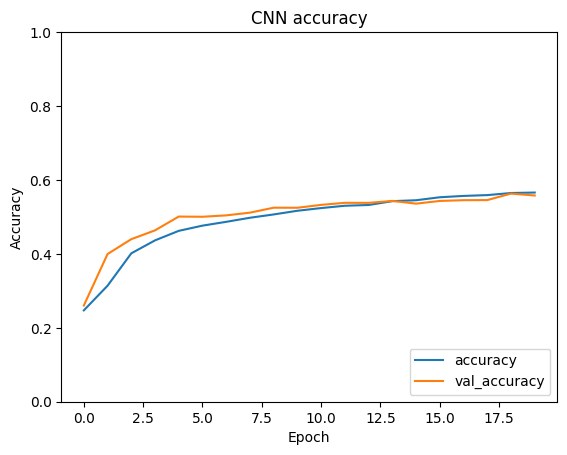

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('CNN accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

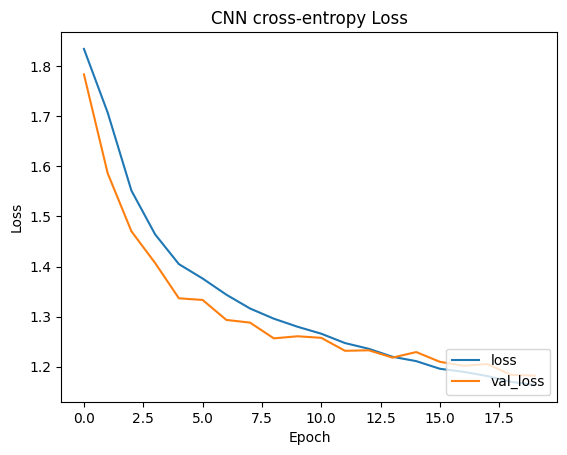

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('CNN cross-entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [1]:
y_true_classes = [np.argmax(i) for i in test_labels]

NameError: name 'test_labels' is not defined

225/225 [==============================] - 2s 8ms/step - loss: 1.1823 - accuracy: 0.5580
Test accuracy: 0.5579548478126526
Test loss: 1.1822586059570312


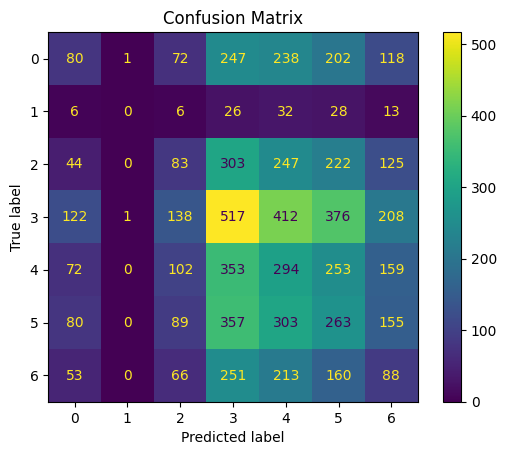

In [17]:
# Load the best saved model
best_model = load_model('best_model.pth')

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(x_test, t_test)

print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.arange(num_classes))
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [15]:
class_accuracies = np.diag(conf_mat) / np.sum(conf_mat, axis=1)

for i, accuracy in enumerate(class_accuracies):
    print(f'Class {i}: Accuracy = {accuracy * 100:.2f}%')

Class 0: Accuracy = 8.35%
Class 1: Accuracy = 0.00%
Class 2: Accuracy = 8.11%
Class 3: Accuracy = 29.14%
Class 4: Accuracy = 23.84%
Class 5: Accuracy = 21.09%
Class 6: Accuracy = 10.59%


In [16]:
total_accuracy = np.sum(np.diag(conf_mat)) / np.sum(conf_mat)

print(f'Total Accuracy: {total_accuracy * 100:.2f}%')

Total Accuracy: 18.46%
